In [1]:
!pip install import-ipynb

import import_ipynb
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from tqdm import tqdm
import gc
import os,logging,pickle,random,torch
import h5py
from matplotlib import pyplot
import pandas as pd
from scipy import stats
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, LSTM, GRU, SimpleRNN, Conv1D, TimeDistributed, MaxPooling1D, Flatten, Dropout, Input, AveragePooling1D, Add, Concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive

datadir = 'Dataset/embedded_data'
drive.mount('/content/drive', force_remount=True)

%cd "drive/MyDrive/Bionformatics_Project/Colab"

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=f102922938fbac92d76e0f366fe7df2b08ae79a89f461ffbe6386a6d3174c047
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1he9S1Es-XalZ9vgCRMbTTNd6cXeRkkFI/Bionformatics_Project/Colab


In [2]:
datadir = 'Dataset/embedded_data'
trainfile = h5py.File(os.path.join(datadir, 'etrain_tf.h5'), 'r')
validfile = h5py.File(os.path.join(datadir, 'evalidation_tf.h5'), 'r')
testfile = h5py.File(os.path.join(datadir, 'etest_tf.h5'), 'r')

X_train_h, X_train, y_train, X_train_tf = trainfile['halflife'], trainfile['promoter'], trainfile['label'], trainfile['tf']
X_val_h, X_validation, y_val, X_val_tf = validfile['halflife'], validfile['promoter'], validfile['label'], validfile['tf']
X_test_h, X_test, y_test, X_test_tf = testfile['halflife'], testfile['promoter'], testfile['label'], testfile['tf']

X_train, X_validation, X_test = np.array(X_train), np.array(X_validation), np.array(X_test)

X_train_h, X_val_h, X_test_h = np.array(X_train_h), np.array(X_val_h), np.array(X_test_h)

X_train_tf, X_val_tf, X_test_tf = np.array(X_train_tf), np.array(X_val_tf), np.array(X_test_tf)

y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

In [ ]:
def compile_model(timestep = 210, features = 64):
  input_promoter = Input(shape=(timestep, features), name='promoter')
  x = layers.BatchNormalization()(input_promoter)
  x = LSTM(units = 100, name='lstm_1',input_shape=(timestep,features))(x)
  x = layers.Dense(90, activation="relu")(x)
  x = layers.Dropout(0.3)(x)
  output = layers.Dense(1, activation="linear")(x)

  model = Model(inputs=(input_promoter), outputs=output)
  model.compile(optimizer='adam', loss='mse')
  return model
model = compile_model()
print(model.summary())

earlystop_cb = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
check_cb = ModelCheckpoint(os.path.join(datadir, 'biolstm.h5'), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=((X_validation), y_val),callbacks=[earlystop_cb,check_cb])
print('last model:')
predictions_test = model.predict([X_test], batch_size=64).flatten()
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions_test, y_test)
print('Test R^2 = %.3f' % r_value**2)
print('best model:')
best_file = os.path.join(datadir, 'biolstm.h5')
model = load_model(best_file)
predictions_test = model.predict([X_test], batch_size=64).flatten()
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions_test, y_test)
print('Test R^2 = %.3f' % r_value**2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
promoter (InputLayer)        [(None, 210, 64)]         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 210, 64)           256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense (Dense)                (None, 90)                9090      
_________________________________________________________________
dropout (Dropout)            (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 91        
Total params: 75,437
Trainable params: 75,309
Non-trainable params: 128
_______________________________________________________

In [ ]:
f_extr = Model(inputs=model.input, outputs=model.get_layer('lstm_1').output)

In [ ]:
m1_train = f_extr.predict(X_train)
m1_val = f_extr.predict(X_validation)
m1_test = f_extr.predict(X_test)

In [ ]:
names_tf = ['ARID3A','ATF1', 'ATF2', 'ATF3', 'BACH1', 'BATF', 'BCL11A', 'BCL3', 'BCLAF1', 'BDP1', 'BHLHE40', 'BRCA1', 'BRF1', 'BRF2', 'CBX2', 'CBX3', 'CBX8', 'CCNT2', 'CEBPB', 'CEBPD', 'CEBPZ', 'CHD1', 'CHD2', 'CHD4', 'CHD7', 'CREB1', 'CREBBP', 'CTBP2', 'CTCF', 'CTCFL', 'CUX1', 'E2F1', 'E2F4', 'E2F6', 'EBF1', 'EGR1', 'ELF1', 'ELK1', 'ELK4', 'EP300', 'ESR1',
  'ESRRA', 'ETS1', 'EZH2', 'FLI1', 'FOS', 'FOSL1', 'FOSL2', 'FOXA1', 'FOXA2', 'FOXM1', 'FOXP2', 'GABPA', 'GATA1', 'GATA2', 'GATA3', 'GTF2B', 'GTF2F1', 'GTF3C2', 'H2AFZ', 'HCFC1', 'HDAC1', 'HDAC2', 'HDAC6', 'HMGN3', 'HNF4A', 'HNF4G', 'HSF1', 'IKZF1', 'IRF1', 'IRF3', 'IRF4', 'JUN', 'JUND', 'KAT2A', 'KAT2B', 'KDM1A', 'KDM4A', 'KDM5A',
 'KDM5B', 'MAFF', 'MAFK', 'MAX', 'MAZ', 'MBD4', 'MEF2A', 'MEF2C', 'MTA3', 'MXI1', 'MYB', 'MYBL2', 'MYC', 'MYOD1', 'MYOG', 'NANOG', 'NCOR1', 'NELFE', 'NFATC1', 'NFE2', 'NFIC', 'NFYA', 'NFYB', 'NR2C2', 'NR2F2', 'NR3C1', 'NRF1', 'PAX5', 'PBX3', 'PHF8', 'PML', 'POLR2A', 'POLR3A', 'POLR3G', 'POU2F2', 'POU5F1', 'PPARGC1A', 'PRDM1', 'RAD21', 'RBBP5', 'RCOR1', 'RELA',
 'REST', 'RFX5', 'RNF2', 'RUNX3', 'RXRA', 'SAP30', 'SETDB1', 'SIN3A', 'SIRT6', 'SIX5', 'SMARCA4', 'SMARCB1', 'SMARCC1', 'SMARCC2', 'SMC3', 'SP1', 'SP2', 'SP4', 'SPI1', 'SREBF1', 'SREBF2', 'SRF', 'STAT1', 'STAT2', 'STAT3', 'STAT5A', 'SUPT20H', 'SUZ12', 'TAF1', 'TAF7', 'TAL1', 'TBL1XR1', 'TBP', 'TCF12', 'TCF3', 'TCF7L2', 'TEAD4', 'TFAP2A',
 'TFAP2C', 'THAP1', 'TRIM28', 'UBTF', 'USF1', 'USF2', 'WHSC1', 'WRNIP1', 'XRCC4', 'YY1', 'ZBTB33', 'ZBTB7A', 'ZC3H11A', 'ZEB1', 'ZKSCAN1', 'ZMIZ1', 'ZNF143', 'ZNF217', 'ZNF263', 'ZNF274', 'ZNF384', 'ZZZ3']

In [ ]:
df_train = pd.DataFrame(np.hstack((m1_train, X_train_h, X_train_tf)))
df_test = pd.DataFrame(np.hstack((m1_test, X_test_h, X_test_tf)))

In [ ]:
fe_names = list(map(lambda x:'f_extr_'+str(x),range(100)))
hf_names = list(map(lambda x:'half_life_'+str(x),range(100,108)))

In [ ]:
df_train.columns = fe_names + hf_names + names_tf
df_test.columns = fe_names + hf_names + names_tf

In [ ]:
importanze = []
for i in range(10):
  rf = RandomForestRegressor(n_jobs=-1)
  rf.fit(df_train, y_train)
  y_hat = rf.predict(df_test)
  r2 = r2_score(y_test, y_hat)
  print(r2)
  importanze.append(rf.feature_importances_)

0.7355115329178907
0.0019352487973907813
0.7348030351984495
0.0018236824418191538
0.7337692591202594
0.0018973354454664207
0.7347123854180235
0.0019177700588180174
0.7351270488873406
0.0018061138024235094
0.7346956209244526
0.0019264623978657953
0.7381705722022341
0.0018613911070914722
0.7318611931409026
0.0017702541703531198
0.731578369683728
0.0017512632295653102
0.7347664174761621
0.001928347724442575


Text(0, 0.5, 'FEATURE NAMES')

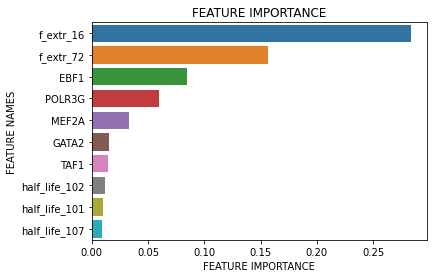

In [ ]:
mean = np.mean(np.array(importanze), axis = 0)
sorted_idx = mean.argsort()
sns.barplot(y=np.flip(df_test.columns[sorted_idx][-10:]), x=np.flip(mean[sorted_idx][-10:]))
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

In [5]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
X_train = svd.fit_transform(X_train_tf)
X_val = svd.transform(X_val_tf)
X_test = svd.transform(X_test_tf)
print(svd.explained_variance_ratio_.sum())

0.8926844298854958


In [7]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_val)
r2 = r2_score(y_val, y_hat)
print(r2)
y_hat = rf.predict(X_test)
r2 = r2_score(y_test, y_hat)
print(r2)

0.6521774140788223
0.6773027063133801


Text(0, 0.5, 'FEATURE NAMES')

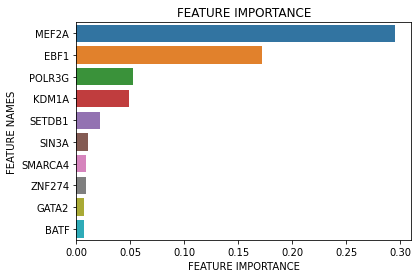

In [ ]:
mean = np.mean(np.array(importanze2), axis = 0)
sorted_idx = mean.argsort()
sns.barplot(y=np.flip(df_test.columns[sorted_idx][-10:]), x=np.flip(mean[sorted_idx][-10:]))
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

In [ ]:
df_train = pd.DataFrame(np.hstack((m1_train, X_train_h)))
df_test = pd.DataFrame(np.hstack((m1_test, X_test_h)))
df_train.columns = fe_names + hf_names
df_test.columns = fe_names + hf_names
importanze3 = []
for i in range(10):
  rf = RandomForestRegressor(n_jobs=-1)
  rf.fit(df_train, y_train)
  perm_importance = permutation_importance(rf, df_test, y_test)
  y_hat = rf.predict(df_test)
  r2 = r2_score(y_test, y_hat)
  print(r2)
  importanze3.append(rf.feature_importances_)

0.6033218311375973
0.6012282029608959
0.6028958521023067
0.5965500517767695
0.5989789642916217
0.6014475113338325
0.6056363629363339
0.6056708020199955
0.6071705826583979
0.5990700608969038


Text(0, 0.5, 'FEATURE NAMES')

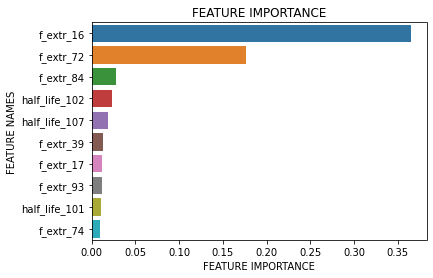

In [ ]:
mean = np.mean(np.array(importanze3), axis = 0)
sorted_idx = mean.argsort()
sns.barplot(y=np.flip(df_test.columns[sorted_idx][-10:]), x=np.flip(mean[sorted_idx][-10:]))
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')